In [0]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
# MNIST dataset
(x_train, y_train), (x_the_test, y_test) = mnist.load_data() # we do not know y_test

print(type(x_train))
x_all, y_all = np.concatenate((x_train, x_the_test), axis=0), np.concatenate((y_train, y_test), axis=0)


x_the_train, x_the_test, y_the_train, y_the_test = train_test_split(x_all, y_all, test_size=0.5, random_state=42) # we do not know y_test, standard kaggle situation

print(len(x_train))




Using TensorFlow backend.


<class 'numpy.ndarray'>
60000


In [0]:
x_combined = np.concatenate((x_the_train, x_the_test), axis=0)
print(len(x_combined))

x_train, x_test = train_test_split(x_combined, test_size=0.2, random_state=42)
print(len(x_train))

70000
56000





Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output

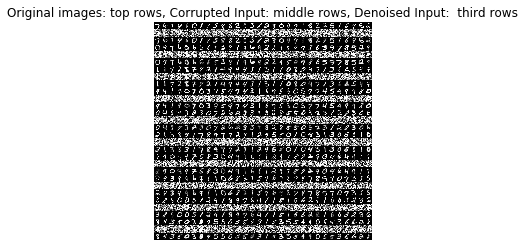

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# # MNIST dataset
# (x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [0]:
from keras import backend as K

def get_nth_layer_output(input_data, n):
    get_layer_output = K.function([encoder.layers[0].input],
                                    [encoder.layers[n].output])
    layer_output = get_layer_output([input_data])[0]

    return layer_output

In [0]:
x_the_train = np.reshape(x_the_train, [-1, image_size, image_size, 1])
x_the_test = np.reshape(x_the_test, [-1, image_size, image_size, 1])
print(x_train.shape, x_the_train.shape)

(56000, 28, 28, 1) (35000, 28, 28, 1)


In [0]:
train_layer_output = get_nth_layer_output(x_the_train, -1)
test_layer_output = get_nth_layer_output(x_the_test, -1)

In [0]:
import pandas as pd
df_train = pd.DataFrame(train_layer_output)

df_test = pd.DataFrame(test_layer_output)


In [0]:
print(df_train)

                0            1   ...           14           15
0      1627.017700  -285.595551  ...  -227.160477  -754.159851
1      1416.308960 -1442.974243  ... -3240.931885  2164.652832
2      -352.989471 -1135.230103  ... -1551.316650 -1212.197021
3      1155.641724  1557.556519  ... -1509.413208  -293.174316
4      1494.928833  1221.031982  ... -2441.872314 -1476.232178
...            ...          ...  ...          ...          ...
34995   905.357849 -2793.937256  ... -2239.110107 -1287.551880
34996   -37.130405  1120.124146  ... -1859.654419  -896.069519
34997  -228.595184 -1299.329956  ... -2143.924561 -1325.307983
34998   558.186584   179.463989  ... -1291.826782     0.782723
34999   235.008820   457.013702  ...  -907.298096  -658.037170

[35000 rows x 16 columns]


In [0]:
label_train = pd.DataFrame(y_the_train, columns=['target'])
label_test = pd.DataFrame(y_the_test, columns=['target'])

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostClassifier

In [0]:
model = CatBoostClassifier(iterations=10000, 
                                   verbose=10,
                                   random_seed=43,
                                   od_type='Iter',
                                   od_wait=500,
                                   train_dir=f'model_dautonn',
                                   task_type='GPU',
                                eval_metric='Accuracy'
                                   )

In [0]:
df_train.columns = list(range(0, len(df_train.columns)))
df_test.columns = list(range(0, len(df_test.columns)))

In [0]:
df_train, df_valid, label_train, label_valid = train_test_split(df_train, label_train, test_size=0.2)

In [0]:
model.fit(df_train, label_train,
                    eval_set=(df_valid, label_valid), 
                    use_best_model=True,
                    )


0:	learn: 0.5810268	test: 0.5694643	best: 0.5694643 (0)	total: 21.1ms	remaining: 3m 31s
10:	learn: 0.7246429	test: 0.7294643	best: 0.7294643 (9)	total: 214ms	remaining: 3m 14s
20:	learn: 0.7661607	test: 0.7614286	best: 0.7614286 (20)	total: 415ms	remaining: 3m 17s
30:	learn: 0.7967411	test: 0.7896429	best: 0.7896429 (30)	total: 585ms	remaining: 3m 8s
40:	learn: 0.8247321	test: 0.8160714	best: 0.8160714 (40)	total: 746ms	remaining: 3m 1s
50:	learn: 0.8432589	test: 0.8350000	best: 0.8350000 (50)	total: 900ms	remaining: 2m 55s
60:	learn: 0.8545089	test: 0.8471429	best: 0.8471429 (60)	total: 1.05s	remaining: 2m 51s
70:	learn: 0.8675893	test: 0.8598214	best: 0.8598214 (70)	total: 1.2s	remaining: 2m 47s
80:	learn: 0.8775000	test: 0.8678571	best: 0.8678571 (80)	total: 1.36s	remaining: 2m 46s
90:	learn: 0.8879464	test: 0.8773214	best: 0.8773214 (90)	total: 1.5s	remaining: 2m 43s
100:	learn: 0.8943750	test: 0.8828571	best: 0.8830357 (99)	total: 1.65s	remaining: 2m 41s
110:	learn: 0.9006250	test

In [0]:
model.score(df_test, label_test)

0.9669142857142857

In [0]:
model = CatBoostClassifier(iterations=10000, 
                                   verbose=10,
                                   random_seed=43,
                                   od_type='Iter',
                                   od_wait=500,
                                   train_dir=f'model_dautonn',
                                   task_type='GPU',
                                eval_metric='Accuracy'
                                   )

In [0]:
n_train, n_valid, label_n_train, label_n_valid = train_test_split(x_the_train, y_the_train)

In [0]:
f_n_train = n_train.reshape(len(n_train), 784)
f_n_valid = n_valid.reshape(len(n_valid), 784)
print(n_train.shape)
print(f_n_train.shape)
print(n_valid.shape)
print(f_n_valid.shape)
print(label_n_train.shape)
print(label_n_valid.shape)

(26250, 28, 28, 1)
(26250, 784)
(8750, 28, 28, 1)
(8750, 784)
(26250,)
(8750,)


In [0]:
model.fit(f_n_train, label_n_train,
                    eval_set=(f_n_valid, label_n_valid), 
                    use_best_model=True,
                    )

0:	learn: 0.5798476	test: 0.5704000	best: 0.5704000 (0)	total: 91.6ms	remaining: 15m 15s
10:	learn: 0.7895619	test: 0.7793143	best: 0.7793143 (10)	total: 613ms	remaining: 9m 16s
20:	learn: 0.8340952	test: 0.8208000	best: 0.8208000 (20)	total: 1.03s	remaining: 8m 10s
30:	learn: 0.8560762	test: 0.8422857	best: 0.8422857 (30)	total: 1.47s	remaining: 7m 52s
40:	learn: 0.8717333	test: 0.8579429	best: 0.8579429 (40)	total: 1.89s	remaining: 7m 38s
50:	learn: 0.8871619	test: 0.8720000	best: 0.8720000 (50)	total: 2.32s	remaining: 7m 32s
60:	learn: 0.8969524	test: 0.8829714	best: 0.8829714 (60)	total: 2.74s	remaining: 7m 25s
70:	learn: 0.9055238	test: 0.8920000	best: 0.8920000 (70)	total: 3.15s	remaining: 7m 19s
80:	learn: 0.9118857	test: 0.8984000	best: 0.8984000 (80)	total: 3.57s	remaining: 7m 16s
90:	learn: 0.9166095	test: 0.9044571	best: 0.9044571 (90)	total: 3.98s	remaining: 7m 12s
100:	learn: 0.9211429	test: 0.9081143	best: 0.9081143 (100)	total: 4.41s	remaining: 7m 12s
110:	learn: 0.92506

In [0]:
model.score(x_the_test.reshape(len(x_the_test), 784), y_the_test)

0.9665428571428571